In [1]:
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from preprocessor import load_and_preprocess, decoding, process_data
from qwen import load_qwen

import numpy as np

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from preprocessor import get_dataset

import wandb
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
best_overall_params = joblib.load("best_overall_params.joblib")

In [4]:
lora_rank = best_overall_params['lora_rank']
lora_alpha = 2*lora_rank
batch_size = 4
learning_rate = best_overall_params['learning_rate']
test_size = 0.2
max_steps = 5000
max_ctx_length = best_overall_params['max_ctx_length']
points = 80
T_max = max_steps
# warmup_steps = int(0.075*max_steps)
# num_training_steps = max_steps

In [5]:
print("lora_rank: ", lora_rank)
print("lora_alpha: ", lora_alpha)
print("learning_rate", learning_rate)
print(max_ctx_length)

lora_rank:  8
lora_alpha:  16
learning_rate 0.0001
768


In [6]:
wandb.init(project="lora_qwen", config={
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "lora_rank": lora_rank,
    "max_steps": max_steps,
    "max_ctx_length": max_ctx_length,
    "test_and_val_size": test_size,
    "T_max": T_max,
    # "warmup_steps": warmup_steps,
    # "num_training_steps": num_training_steps
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ljustfung (ljustfung-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

def evaluate_model(model, val_loader, step, max_batches=None):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(tqdm(val_loader, desc="val set")):
            # Exit loop after processing max_batches
            if max_batches is not None and batch_idx >= max_batches:
                break
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            total_loss += loss.item()
            
    
    # Calculate metrics - divide by actual number of batches processed
    num_batches = min(len(val_loader), max_batches) if max_batches is not None else len(val_loader)
    avg_loss = total_loss / num_batches

    print(f'Loss on validation subset ({num_batches}/{len(val_loader)} batches) at step {step}: {avg_loss:.4f}')
    return avg_loss

In [8]:
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


model, tokenizer = load_qwen()
tokenizer.padding_side = 'left'

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
# ^These are the parts that will actually be trained!

for name, param in model.named_parameters():
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Process the data into sequences of text
train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

In [9]:
# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False, padding_side='left')
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                        chunk,
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)


def process_data(texts, tokenizer, points=80):
    given_input_ids = []
    for text in texts:
        given_text = ';'.join([chunk for i, chunk in enumerate(text.split(';')) if i < points])
        encoding_given = tokenizer(given_text, return_tensors="pt", padding='max_length', padding_side='left', max_length=1200)
        given_input_ids.append(encoding_given.input_ids[0])
    return np.stack([text for text in texts]), torch.stack(given_input_ids)

# Defines the maximum context length for the model
train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)
test_texts_all, test_input_ids_some = process_data(
    test_texts, tokenizer, points=points
)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)

# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = CosineAnnealingLR(optimizer, T_max=max_steps)
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids_some)
test_loader = DataLoader(test_dataset, shuffle=False)

# Prepare components with Accelerator
accelerator = Accelerator(mixed_precision='fp16')
model, optimizer, train_loader, scheduler, val_loader = accelerator.prepare(model, optimizer, 
                                                                                         train_loader, 
                                                                                         scheduler, 
                                                                                         val_loader
                                                                                         )

In [10]:
# Train the model
steps = 0
train_losses = []
val_losses = []
while steps < max_steps:
    progress_bar = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        train_losses.append([loss.item(), steps])
        accelerator.backward(loss)
        optimizer.step()
        scheduler.step()
        steps += 1

        progress_bar.set_postfix(loss=loss.item())

        wandb.log({
            "train_loss": loss.item(),
            "steps": steps,
            "lr": optimizer.param_groups[0]['lr'],
            })

        if (steps % 50) == 0:
            avg_loss = evaluate_model(model, val_loader, steps)
            val_losses.append([avg_loss, steps])
            model.eval()

            wandb.log({
            "val_loss": avg_loss,
            "steps": steps,
            })

        if steps > max_steps:
            break    

Steps 0:   6%|▋         | 50/800 [07:34<8:51:36, 42.53s/it, loss=0.557]

Loss on validation subset (50/50 batches) at step 50: 0.7882


Steps 0:  12%|█▎        | 100/800 [13:48<6:50:54, 35.22s/it, loss=0.748]

Loss on validation subset (50/50 batches) at step 100: 0.7212


Steps 0:  19%|█▉        | 150/800 [21:14<10:42:01, 59.26s/it, loss=0.595]

Loss on validation subset (50/50 batches) at step 150: 0.6899


Steps 0:  25%|██▌       | 200/800 [32:04<9:15:08, 55.51s/it, loss=0.533]

Loss on validation subset (50/50 batches) at step 200: 0.6666


Steps 0:  31%|███▏      | 250/800 [43:27<9:24:15, 61.56s/it, loss=0.619]

Loss on validation subset (50/50 batches) at step 250: 0.6536


Steps 0:  38%|███▊      | 300/800 [56:04<8:40:53, 62.51s/it, loss=0.265]

Loss on validation subset (50/50 batches) at step 300: 0.6435


Steps 0:  44%|████▍     | 350/800 [1:08:30<8:36:03, 68.81s/it, loss=0.305]

Loss on validation subset (50/50 batches) at step 350: 0.6336


Steps 0:  50%|█████     | 400/800 [1:23:19<10:44:15, 96.64s/it, loss=0.634]

Loss on validation subset (50/50 batches) at step 400: 0.6285


Steps 0:  56%|█████▋    | 450/800 [1:30:44<4:20:34, 44.67s/it, loss=0.452]

Loss on validation subset (50/50 batches) at step 450: 0.6193


Steps 0:  62%|██████▎   | 500/800 [1:45:32<6:29:24, 77.88s/it, loss=0.456]

Loss on validation subset (50/50 batches) at step 500: 0.6159


Steps 0:  69%|██████▉   | 550/800 [1:56:30<2:20:49, 33.80s/it, loss=0.421]

Loss on validation subset (50/50 batches) at step 550: 0.6063


Steps 0:  75%|███████▌  | 600/800 [2:03:42<2:03:28, 37.04s/it, loss=0.558]

Loss on validation subset (50/50 batches) at step 600: 0.6013


Steps 0:  81%|████████▏ | 650/800 [2:10:40<1:37:09, 38.86s/it, loss=0.72]

Loss on validation subset (50/50 batches) at step 650: 0.6024


Steps 0:  88%|████████▊ | 700/800 [2:22:30<2:03:54, 74.35s/it, loss=0.725]

Loss on validation subset (50/50 batches) at step 700: 0.5945


Steps 0:  94%|█████████▍| 750/800 [2:34:38<53:57, 64.74s/it, loss=0.334]

Loss on validation subset (50/50 batches) at step 750: 0.5954


Steps 0: 100%|██████████| 800/800 [2:46:11<00:00, 12.46s/it, loss=0.673]


Loss on validation subset (50/50 batches) at step 800: 0.5901


Steps 800:   6%|▋         | 50/800 [12:32<13:11:32, 63.32s/it, loss=0.541]

Loss on validation subset (50/50 batches) at step 850: 0.5847


Steps 800:  12%|█▎        | 100/800 [25:25<11:40:19, 60.03s/it, loss=0.459]

Loss on validation subset (50/50 batches) at step 900: 0.5807


Steps 800:  19%|█▉        | 150/800 [38:17<14:28:18, 80.15s/it, loss=0.27]

Loss on validation subset (50/50 batches) at step 950: 0.5837


Steps 800:  25%|██▌       | 200/800 [54:50<17:52:18, 107.23s/it, loss=0.74]

Loss on validation subset (50/50 batches) at step 1000: 0.5755


Steps 800:  31%|███▏      | 250/800 [1:08:20<12:51:18, 84.14s/it, loss=0.379]

Loss on validation subset (50/50 batches) at step 1050: 0.5692


Steps 800:  38%|███▊      | 300/800 [1:22:38<12:05:48, 87.10s/it, loss=0.771]

Loss on validation subset (50/50 batches) at step 1100: 0.5683


Steps 800:  44%|████▍     | 350/800 [1:37:41<11:30:49, 92.11s/it, loss=0.735]

Loss on validation subset (50/50 batches) at step 1150: 0.5689


Steps 800:  50%|█████     | 400/800 [1:52:38<9:54:06, 89.12s/it, loss=0.409]

Loss on validation subset (50/50 batches) at step 1200: 0.5691


Steps 800:  56%|█████▋    | 450/800 [2:07:18<8:34:09, 88.14s/it, loss=0.53]

Loss on validation subset (50/50 batches) at step 1250: 0.5656


Steps 800:  62%|██████▎   | 500/800 [2:19:54<6:16:28, 75.29s/it, loss=0.204]

Loss on validation subset (50/50 batches) at step 1300: 0.5607


Steps 800:  69%|██████▉   | 550/800 [2:35:46<6:53:56, 99.35s/it, loss=0.55]

Loss on validation subset (50/50 batches) at step 1350: 0.5615


Steps 800:  75%|███████▌  | 600/800 [2:49:49<4:41:28, 84.44s/it, loss=0.621]

Loss on validation subset (50/50 batches) at step 1400: 0.5617


Steps 800:  81%|████████▏ | 650/800 [3:05:07<3:59:20, 95.74s/it, loss=0.517]

Loss on validation subset (50/50 batches) at step 1450: 0.5568


Steps 800:  88%|████████▊ | 700/800 [3:19:23<2:21:03, 84.63s/it, loss=0.568]

Loss on validation subset (50/50 batches) at step 1500: 0.5539


Steps 800:  94%|█████████▍| 750/800 [3:33:28<1:10:17, 84.36s/it, loss=0.596]

Loss on validation subset (50/50 batches) at step 1550: 0.5511


Steps 800: 100%|██████████| 800/800 [3:47:45<00:00, 17.08s/it, loss=0.251]


Loss on validation subset (50/50 batches) at step 1600: 0.5523


Steps 1600:   6%|▋         | 50/800 [12:03<15:03:09, 72.25s/it, loss=0.417]

Loss on validation subset (50/50 batches) at step 1650: 0.5555


Steps 1600:  12%|█▎        | 100/800 [24:31<14:21:53, 73.88s/it, loss=0.7]

Loss on validation subset (50/50 batches) at step 1700: 0.5475


Steps 1600:  19%|█▉        | 150/800 [38:30<15:19:14, 84.85s/it, loss=0.519]

Loss on validation subset (50/50 batches) at step 1750: 0.5479


Steps 1600:  25%|██▌       | 200/800 [52:24<14:04:36, 84.46s/it, loss=0.46]

Loss on validation subset (50/50 batches) at step 1800: 0.5479


Steps 1600:  31%|███▏      | 250/800 [1:06:39<13:03:36, 85.48s/it, loss=0.584]

Loss on validation subset (50/50 batches) at step 1850: 0.5441


Steps 1600:  38%|███▊      | 300/800 [1:22:18<13:45:27, 99.05s/it, loss=0.554]

Loss on validation subset (50/50 batches) at step 1900: 0.5450


Steps 1600:  44%|████▍     | 350/800 [1:35:10<9:35:26, 76.72s/it, loss=0.488]

Loss on validation subset (50/50 batches) at step 1950: 0.5442


Steps 1600:  50%|█████     | 400/800 [1:49:37<9:32:38, 85.90s/it, loss=0.28]

Loss on validation subset (50/50 batches) at step 2000: 0.5436


Steps 1600:  56%|█████▋    | 450/800 [2:04:10<8:25:38, 86.68s/it, loss=0.261]

Loss on validation subset (50/50 batches) at step 2050: 0.5399


Steps 1600:  62%|██████▎   | 500/800 [2:17:38<6:47:35, 81.52s/it, loss=0.313]

Loss on validation subset (50/50 batches) at step 2100: 0.5391


Steps 1600:  69%|██████▉   | 550/800 [2:31:38<5:55:45, 85.38s/it, loss=0.556]

Loss on validation subset (50/50 batches) at step 2150: 0.5386


Steps 1600:  75%|███████▌  | 600/800 [2:46:19<5:05:25, 91.63s/it, loss=0.219]

Loss on validation subset (50/50 batches) at step 2200: 0.5394


Steps 1600:  81%|████████▏ | 650/800 [3:00:30<3:34:19, 85.73s/it, loss=0.413]

Loss on validation subset (50/50 batches) at step 2250: 0.5353


Steps 1600:  88%|████████▊ | 700/800 [3:13:26<2:08:50, 77.30s/it, loss=0.462]

Loss on validation subset (50/50 batches) at step 2300: 0.5384


Steps 1600:  94%|█████████▍| 750/800 [3:28:12<1:12:17, 86.76s/it, loss=0.537]

Loss on validation subset (50/50 batches) at step 2350: 0.5326


Steps 1600: 100%|██████████| 800/800 [3:42:52<00:00, 16.72s/it, loss=0.584]


Loss on validation subset (50/50 batches) at step 2400: 0.5363


Steps 2400:   6%|▋         | 50/800 [14:17<17:59:05, 86.33s/it, loss=0.524]

Loss on validation subset (50/50 batches) at step 2450: 0.5353


Steps 2400:  12%|█▎        | 100/800 [28:49<16:45:41, 86.20s/it, loss=0.652]

Loss on validation subset (50/50 batches) at step 2500: 0.5313


Steps 2400:  19%|█▉        | 150/800 [42:55<15:40:04, 86.78s/it, loss=0.397]

Loss on validation subset (50/50 batches) at step 2550: 0.5304


Steps 2400:  25%|██▌       | 200/800 [56:55<13:51:47, 83.18s/it, loss=0.531]

Loss on validation subset (50/50 batches) at step 2600: 0.5306


Steps 2400:  31%|███▏      | 250/800 [1:12:36<15:16:27, 99.98s/it, loss=0.361]

Loss on validation subset (50/50 batches) at step 2650: 0.5340


Steps 2400:  38%|███▊      | 300/800 [1:28:17<13:55:27, 100.25s/it, loss=0.361]

Loss on validation subset (50/50 batches) at step 2700: 0.5310


Steps 2400:  44%|████▍     | 350/800 [1:43:32<11:18:12, 90.43s/it, loss=0.505]

Loss on validation subset (50/50 batches) at step 2750: 0.5262


Steps 2400:  50%|█████     | 400/800 [1:58:24<8:13:12, 73.98s/it, loss=0.483]

Loss on validation subset (50/50 batches) at step 2800: 0.5305


Steps 2400:  56%|█████▋    | 450/800 [2:04:31<3:00:29, 30.94s/it, loss=0.215]

Loss on validation subset (50/50 batches) at step 2850: 0.5293


Steps 2400:  62%|██████▎   | 500/800 [2:10:37<2:54:00, 34.80s/it, loss=0.421]

Loss on validation subset (50/50 batches) at step 2900: 0.5263


Steps 2400:  69%|██████▉   | 550/800 [2:16:50<2:18:04, 33.14s/it, loss=0.366]

Loss on validation subset (50/50 batches) at step 2950: 0.5276


Steps 2400:  75%|███████▌  | 600/800 [2:23:13<2:00:15, 36.08s/it, loss=0.387]

Loss on validation subset (50/50 batches) at step 3000: 0.5256


Steps 2400:  81%|████████▏ | 650/800 [2:29:28<1:23:34, 33.43s/it, loss=0.34]

Loss on validation subset (50/50 batches) at step 3050: 0.5251


Steps 2400:  88%|████████▊ | 700/800 [2:35:44<52:52, 31.72s/it, loss=0.31]

Loss on validation subset (50/50 batches) at step 3100: 0.5222


Steps 2400:  94%|█████████▍| 750/800 [2:41:51<26:32, 31.86s/it, loss=0.404]

Loss on validation subset (50/50 batches) at step 3150: 0.5219


Steps 2400: 100%|██████████| 800/800 [2:47:44<00:00, 12.58s/it, loss=0.348]


Loss on validation subset (50/50 batches) at step 3200: 0.5217


Steps 3200:   6%|▋         | 50/800 [05:54<6:41:20, 32.11s/it, loss=0.488]

Loss on validation subset (50/50 batches) at step 3250: 0.5217


Steps 3200:  12%|█▎        | 100/800 [11:49<6:12:02, 31.89s/it, loss=0.39]

Loss on validation subset (50/50 batches) at step 3300: 0.5224


Steps 3200:  19%|█▉        | 150/800 [17:40<5:43:25, 31.70s/it, loss=0.256]

Loss on validation subset (50/50 batches) at step 3350: 0.5208


Steps 3200:  25%|██▌       | 200/800 [23:34<5:17:16, 31.73s/it, loss=0.449]

Loss on validation subset (50/50 batches) at step 3400: 0.5202


Steps 3200:  31%|███▏      | 250/800 [29:28<4:54:03, 32.08s/it, loss=0.225]

Loss on validation subset (50/50 batches) at step 3450: 0.5198


Steps 3200:  38%|███▊      | 300/800 [35:41<4:42:57, 33.95s/it, loss=0.337]

Loss on validation subset (50/50 batches) at step 3500: 0.5189


Steps 3200:  44%|████▍     | 350/800 [41:57<4:15:20, 34.05s/it, loss=0.37]

Loss on validation subset (50/50 batches) at step 3550: 0.5182


Steps 3200:  50%|█████     | 400/800 [47:58<3:38:34, 32.79s/it, loss=0.499]

Loss on validation subset (50/50 batches) at step 3600: 0.5184


Steps 3200:  56%|█████▋    | 450/800 [53:55<3:09:36, 32.50s/it, loss=0.531]

Loss on validation subset (50/50 batches) at step 3650: 0.5183


Steps 3200:  62%|██████▎   | 500/800 [59:55<2:43:09, 32.63s/it, loss=0.452]

Loss on validation subset (50/50 batches) at step 3700: 0.5181


Steps 3200:  69%|██████▉   | 550/800 [1:05:51<2:22:32, 34.21s/it, loss=0.408]

Loss on validation subset (50/50 batches) at step 3750: 0.5174


Steps 3200:  75%|███████▌  | 600/800 [1:11:53<1:54:23, 34.32s/it, loss=0.118]

Loss on validation subset (50/50 batches) at step 3800: 0.5170


Steps 3200:  81%|████████▏ | 650/800 [1:18:01<1:23:44, 33.50s/it, loss=0.646]

Loss on validation subset (50/50 batches) at step 3850: 0.5156


Steps 3200:  88%|████████▊ | 700/800 [1:24:10<56:09, 33.69s/it, loss=0.277]

Loss on validation subset (50/50 batches) at step 3900: 0.5162


Steps 3200:  94%|█████████▍| 750/800 [1:30:15<29:32, 35.45s/it, loss=0.651]

Loss on validation subset (50/50 batches) at step 3950: 0.5160


Steps 3200: 100%|██████████| 800/800 [1:35:58<00:00,  7.20s/it, loss=0.323]


Loss on validation subset (50/50 batches) at step 4000: 0.5159


Steps 4000:   6%|▋         | 50/800 [05:51<6:31:25, 31.31s/it, loss=0.292]

Loss on validation subset (50/50 batches) at step 4050: 0.5156


Steps 4000:  12%|█▎        | 100/800 [11:28<5:54:42, 30.40s/it, loss=0.396]

Loss on validation subset (50/50 batches) at step 4100: 0.5154


Steps 4000:  19%|█▉        | 150/800 [17:00<5:24:51, 29.99s/it, loss=0.303]

Loss on validation subset (50/50 batches) at step 4150: 0.5148


Steps 4000:  25%|██▌       | 200/800 [22:35<5:03:26, 30.34s/it, loss=0.468]

Loss on validation subset (50/50 batches) at step 4200: 0.5149


Steps 4000:  31%|███▏      | 250/800 [28:09<4:34:40, 29.97s/it, loss=0.346]

Loss on validation subset (50/50 batches) at step 4250: 0.5147


Steps 4000:  38%|███▊      | 300/800 [33:44<4:13:19, 30.40s/it, loss=0.546]

Loss on validation subset (50/50 batches) at step 4300: 0.5143


Steps 4000:  44%|████▍     | 350/800 [39:19<3:46:23, 30.19s/it, loss=0.537]

Loss on validation subset (50/50 batches) at step 4350: 0.5144


Steps 4000:  50%|█████     | 400/800 [44:54<3:22:44, 30.41s/it, loss=0.342]

Loss on validation subset (50/50 batches) at step 4400: 0.5145


Steps 4000:  56%|█████▋    | 450/800 [50:27<2:54:25, 29.90s/it, loss=0.24]

Loss on validation subset (50/50 batches) at step 4450: 0.5142


Steps 4000:  62%|██████▎   | 500/800 [56:02<2:30:47, 30.16s/it, loss=0.59]

Loss on validation subset (50/50 batches) at step 4500: 0.5141


Steps 4000:  69%|██████▉   | 550/800 [1:01:34<2:04:22, 29.85s/it, loss=0.398]

Loss on validation subset (50/50 batches) at step 4550: 0.5142


Steps 4000:  75%|███████▌  | 600/800 [1:07:09<1:40:20, 30.10s/it, loss=0.481]

Loss on validation subset (50/50 batches) at step 4600: 0.5137


Steps 4000:  81%|████████▏ | 650/800 [1:12:44<1:15:21, 30.14s/it, loss=0.221]

Loss on validation subset (50/50 batches) at step 4650: 0.5137


Steps 4000:  88%|████████▊ | 700/800 [1:18:18<50:04, 30.04s/it, loss=0.402]

Loss on validation subset (50/50 batches) at step 4700: 0.5136


Steps 4000:  94%|█████████▍| 750/800 [1:23:52<25:03, 30.08s/it, loss=0.318]

Loss on validation subset (50/50 batches) at step 4750: 0.5136


Steps 4000: 100%|██████████| 800/800 [1:29:26<00:00,  6.71s/it, loss=0.422]


Loss on validation subset (50/50 batches) at step 4800: 0.5135


Steps 4800:   6%|▋         | 50/800 [05:34<6:17:15, 30.18s/it, loss=0.501]

Loss on validation subset (50/50 batches) at step 4850: 0.5135


Steps 4800:  12%|█▎        | 100/800 [11:07<5:48:39, 29.88s/it, loss=0.413]

Loss on validation subset (50/50 batches) at step 4900: 0.5136


Steps 4800:  19%|█▉        | 150/800 [16:41<5:25:48, 30.07s/it, loss=0.287]

Loss on validation subset (50/50 batches) at step 4950: 0.5136


Steps 4800:  25%|██▌       | 200/800 [22:15<5:00:37, 30.06s/it, loss=0.425]

Loss on validation subset (50/50 batches) at step 5000: 0.5136


Steps 4800:  25%|██▌       | 200/800 [22:21<1:07:03,  6.71s/it, loss=0.468]


In [11]:
# Unwrap model from accelerator
unwrapped_model = accelerator.unwrap_model(model)

# Create a dictionary to store LoRA weights
lora_state_dict = {}

# Extract LoRA weights from each layer
for i, layer in enumerate(unwrapped_model.model.layers):
    # Save Q projection LoRA weights
    if hasattr(layer.self_attn.q_proj, 'A'):
        lora_state_dict[f'layer_{i}.self_attn.q_proj.A'] = layer.self_attn.q_proj.A.detach().cpu()
        lora_state_dict[f'layer_{i}.self_attn.q_proj.B'] = layer.self_attn.q_proj.B.detach().cpu()
    
    # Save V projection LoRA weights
    if hasattr(layer.self_attn.v_proj, 'A'):
        lora_state_dict[f'layer_{i}.self_attn.v_proj.A'] = layer.self_attn.v_proj.A.detach().cpu()
        lora_state_dict[f'layer_{i}.self_attn.v_proj.B'] = layer.self_attn.v_proj.B.detach().cpu()

# Save metadata
lora_state_dict['config'] = {
    'lora_rank': lora_rank,
    'lora_alpha': lora_alpha,
    'max_ctx_length': max_ctx_length
}

# Save to file
torch.save(lora_state_dict, f"../models/{wandb.run.name}_lora_weights.pt")
torch.save(optimizer.state_dict(), f"../models/{wandb.run.name}_optimizer_state.pth")
torch.save(scheduler.state_dict(), f"../models/{wandb.run.name}_scheduler_state.pth")

[2025-03-30 00:55:16,742] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [12]:
# # Load the saved LoRA weights
# saved_model_path = f"../models/{wandb.run.name}_lora_weights.pt"
# lora_state_dict = torch.load(saved_model_path)
# print(f"Loading LoRA weights from {saved_model_path}")

# # Extract configuration
# loaded_config = lora_state_dict.get('config', {})
# print(f"Loaded model config: {loaded_config}")

# # Load weights into model
# unwrapped_model = accelerator.unwrap_model(model)
# for i, layer in enumerate(unwrapped_model.model.layers):
#     # Load Q projection LoRA weights
#     if f'layer_{i}.self_attn.q_proj.A' in lora_state_dict:
#         layer.self_attn.q_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.A'].to(layer.self_attn.q_proj.A.device)
#         layer.self_attn.q_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.B'].to(layer.self_attn.q_proj.B.device)
    
#     # Load V projection LoRA weights
#     if f'layer_{i}.self_attn.v_proj.A' in lora_state_dict:
#         layer.self_attn.v_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.A'].to(layer.self_attn.v_proj.A.device)
#         layer.self_attn.v_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.B'].to(layer.self_attn.v_proj.B.device)

# print("LoRA weights loaded successfully")

In [13]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

results = {}

results['train_losses'] = train_losses
results['val_losses'] = val_losses


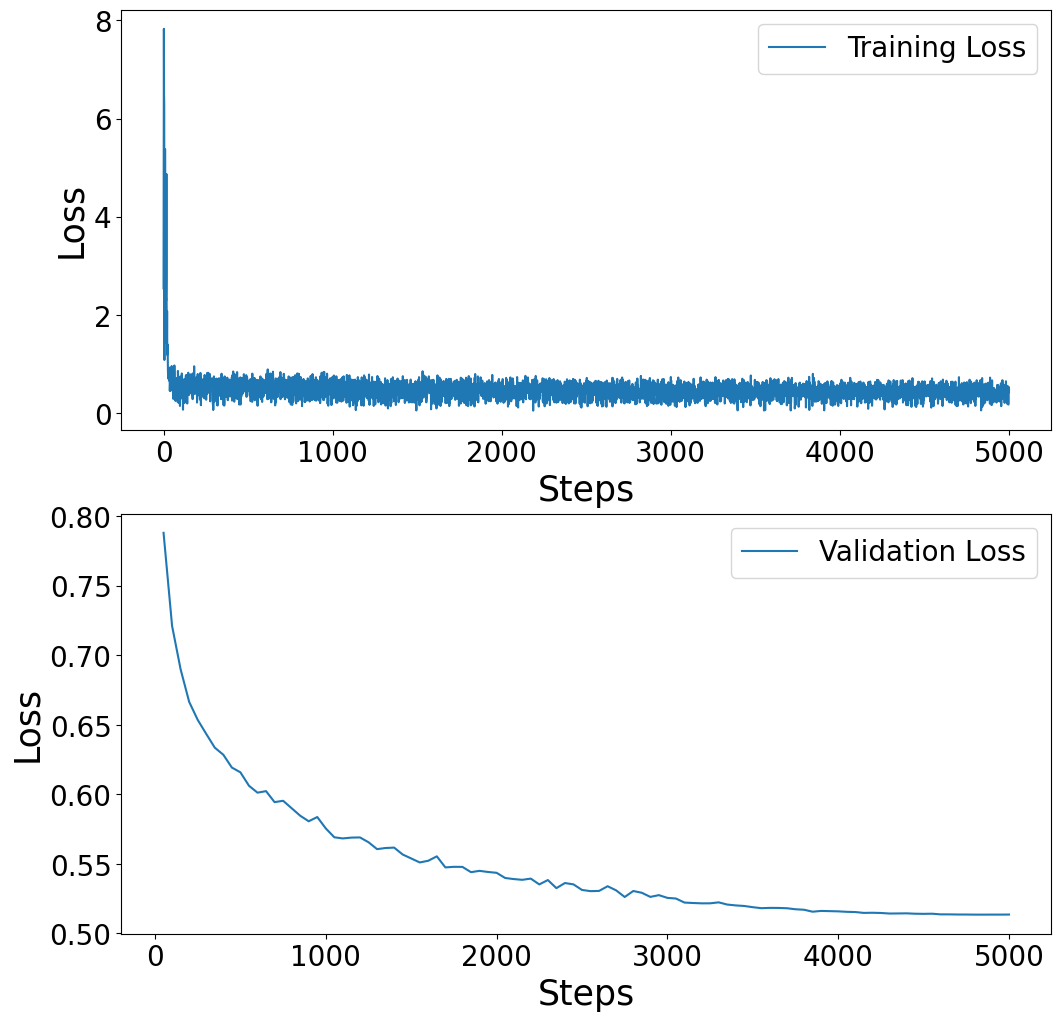

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(train_losses[:, 1], train_losses[:, 0], label="Training Loss")
ax[1].plot(val_losses[:, 1], val_losses[:, 0], label="Validation Loss")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.savefig(f"../plots/{wandb.run.name}_loss.png")
plt.show()

In [15]:
model.eval

<bound method Module.eval of Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attent

In [16]:
torch.cuda.empty_cache()

In [17]:
accelerator = Accelerator()
model, test_loader = accelerator.prepare(model, test_loader)

In [18]:
model.eval()
with torch.no_grad():    
    for (batch,) in tqdm(test_loader):
        outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction_decoded = decoding(prediction)
        break

test_decoded = decoding(test_texts_all[0])

  0%|          | 0/100 [01:01<?, ?it/s]


In [ ]:
results['prediction_decoded'] = prediction_decoded
results['test_decoded'] = test_decoded

In [19]:
import h5py
with h5py.File("lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]
    prey = trajectories[:, :, 0]
    predator = trajectories[:, :, 1]
    times = time_points[:]
    
def scaler(prey, predator, alpha, decimals=3):
    prey = np.array(prey)
    predator = np.array(predator)
    data = np.stack([prey, predator], axis=-1)
    rescaled = data/alpha * 10
    return np.round(rescaled, decimals = decimals)

def encoding(prey, predator):
    series = np.column_stack((prey, predator))
    encoded = ';'.join([','.join(map(str, row)) for row in series])
    return encoded

dataset = scaler(prey, predator, 5)
encoded = [encoding(prey, predator) for prey, predator in zip(dataset[:,0], dataset[:,1])]

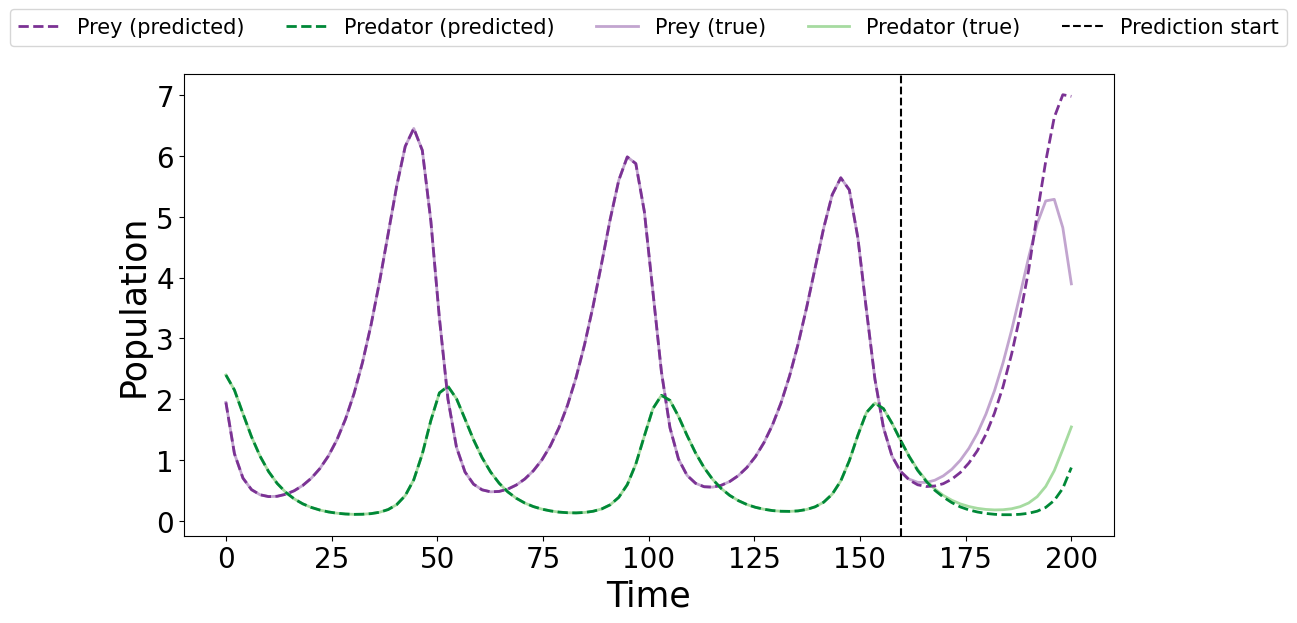

In [20]:
colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
_, _, time = get_dataset()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
plt.savefig(f'../plots/{wandb.run.name}_inspection.png')
plt.show()


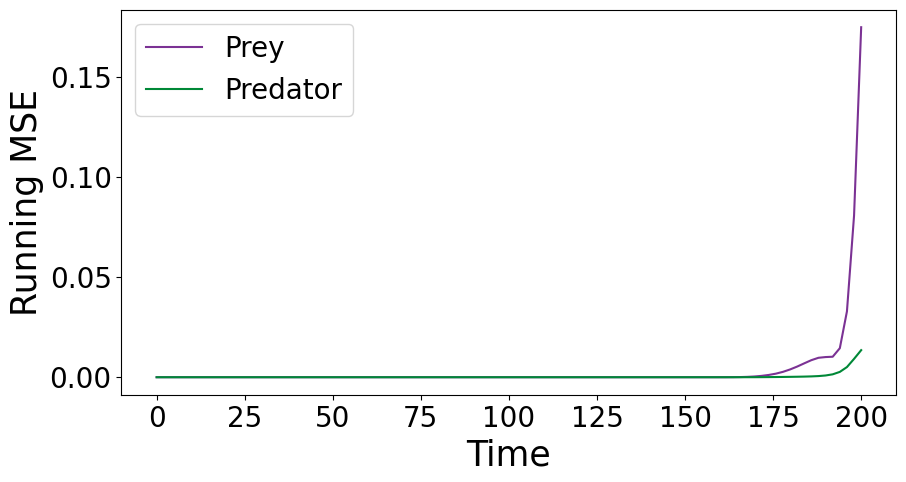

In [21]:
running_mse_prey = running_mse(prediction_decoded[0], test_decoded[0])
running_mse_predator = running_mse(prediction_decoded[1], test_decoded[1])
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_title(f"Running MSE")
ax.plot(times, running_mse_prey, label="Prey", color=colours[0])
ax.plot(times, running_mse_predator, label="Predator", color=colours[3])
ax.set_xlabel("Time")
ax.set_ylabel("Running MSE")
ax.legend()
plt.savefig(f"../plots/{wandb.run.name}_running_mse.png")
plt.show()

In [ ]:
pred_prey = prediction_decoded[0]
pred_predator = prediction_decoded[1]
actual_prey = test_decoded[0]
actual_predator = test_decoded[1]

mean_prey_squared_error = mean_squared_error(pred_prey, actual_prey)
mean_prey_absolute_error = mean_absolute_error(pred_prey, actual_prey)
r2_prey_score = r2_score(pred_prey, actual_prey)
mean_predator_squared_error = mean_squared_error(pred_predator, actual_predator)
mean_predator_absolute_error = mean_absolute_error(pred_predator, actual_predator)
r2_predator_score = r2_score(pred_predator, actual_predator)

print("MEAN PREY SQUARED ERROR:", mean_prey_squared_error)
print("MEAN PREY ABSOLUTE ERROR:", mean_prey_absolute_error)
print("R2 PREY SCORE:", r2_prey_score)
print("MEAN PREDATOR SQUARED ERROR:", mean_predator_squared_error)
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_predator_absolute_error)
print("R2 PREDATOR SCORE:", r2_predator_score)

results['metrics'] = {
    "mean_prey_squared_error": mean_prey_squared_error,
    "mean_prey_absolute_error": mean_prey_absolute_error,
    "r2_prey_score": r2_prey_score,
    "mean_predator_squared_error": mean_predator_squared_error,
    "mean_predator_absolute_error": mean_predator_absolute_error,
    "r2_predator_score": r2_predator_score,
    "running_mse_prey": running_mse_prey,
    "running_mse_predator": running_mse_predator,
}

joblib.dump(results, f"../results/lora_run_{wandb.run.name}.pkl")

MEAN PREY SQUARED ERROR: 0.17490840000000002
MEAN PREY ABSOLUTE ERROR: 0.10702
R2 PREY SCORE: 0.9552232727638801
MEAN PREDATOR SQUARED ERROR: 0.013529649999999999
MEAN PREDATOR ABSOLUTE ERROR: 0.03277
R2 PREDATOR SCORE: 0.9676410681096241


['../results/lora_run_deep-sky-30.pkl']